# 数据探索性分析与数据预处理——Oakland Crime Statistics 2011 to 2016

代码仓库链接:https://github.com/gejingjing/Data-Mining/tree/master/homework1

## 1.数据预览

由于该数据集有六个数据文件，分别记录了每年的犯罪数据，因此可以进行数据集合并，进行共同的数据分析

In [1]:
import pandas as pd
import time
import re
import matplotlib.pyplot as plt
from pandas import DataFrame,Series
import numpy as np
import missingno as msno 
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import seaborn as sns
from sklearn import linear_model
from scipy import stats
pd.set_option('max_colwidth',100)
root_dir = 'Oakland Crime Statistics 2011 to 2016/records-for-'
csv_file = 'Oakland Crime Statistics 2011 to 2016/records-for-2011.csv'
data = pd.read_csv(csv_file,sep=",", header=0)

for i in range(2012,2017):
    df_load = pd.read_csv(root_dir+str(i)+".csv", sep=",", header=0)
    data = data.append(df_load, ignore_index=True, sort=False)
    del df_load

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046388 entries, 0 to 1046387
Data columns (total 13 columns):
Agency                       1046384 non-null object
Create Time                  1046384 non-null object
Location                     483425 non-null object
Area Id                      864023 non-null object
Beat                         1040583 non-null object
Priority                     1046384 non-null float64
Incident Type Id             1046384 non-null object
Incident Type Description    1045996 non-null object
Event Number                 1046384 non-null object
Closed Time                  1046359 non-null object
Location 1                   374799 non-null object
Zip Codes                    352 non-null float64
Location                     188052 non-null object
dtypes: float64(2), object(11)
memory usage: 103.8+ MB


发现存在两个问题首先因为有数据文件中的'Location'属性多打了一个空格变成'Location '，不同的列名导致数据读取的时候没有进行合并，下面进行合并

In [2]:
data.loc[data['Location '].notnull(),['Location']] = data['Location '][data['Location '].notnull()]
data = data.drop('Location ',axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046388 entries, 0 to 1046387
Data columns (total 12 columns):
Agency                       1046384 non-null object
Create Time                  1046384 non-null object
Location                     671477 non-null object
Area Id                      864023 non-null object
Beat                         1040583 non-null object
Priority                     1046384 non-null float64
Incident Type Id             1046384 non-null object
Incident Type Description    1045996 non-null object
Event Number                 1046384 non-null object
Closed Time                  1046359 non-null object
Location 1                   374799 non-null object
Zip Codes                    352 non-null float64
dtypes: float64(2), object(10)
memory usage: 95.8+ MB


可以看出属性'Location '已经消失，同时属性'Location'增加了相应的数据项，接下来解决第二个问题，在部分文件中位置的存储使用的是Location 1，接下来进行输出观察Location 1与属性Location的区别

In [3]:
display(data['Location'][data['Location'].notnull()].head(5))
data['Location 1'][data['Location 1'].notnull()].head(5)

0       ST&SAN PABLO AV
1         ST&HANNAH ST 
2         ST&MARKET ST 
3          PRENTISS ST 
4     AV&FOOTHILL BLVD 
Name: Location, dtype: object

180016             {'human_address': '{"address": "OLIVE ST", "city": "", "state": "", "zip": ""}'}
180017    {'human_address': '{"address": "AV&MACARTHUR BLVD", "city": "", "state": "", "zip": ""}'}
180018          {'human_address': '{"address": "SYCAMORE ST", "city": "", "state": "", "zip": ""}'}
180019    {'human_address': '{"address": "AV&MACARTHUR BLVD", "city": "", "state": "", "zip": ""}'}
180020           {'human_address': '{"address": "ST&WOOD ST", "city": "", "state": "", "zip": ""}'}
Name: Location 1, dtype: object

可以看出位置信息存贮在Location 1字典中的address中，利用正则化匹配提取位置信息

In [4]:
Location = data['Location 1'][data['Location 1'].notnull()].apply(lambda x: re.findall("\"address\": \"(.*?)\", \"city\"", x)[0])
Location.head(5)

180016             OLIVE ST
180017    AV&MACARTHUR BLVD
180018          SYCAMORE ST
180019    AV&MACARTHUR BLVD
180020           ST&WOOD ST
Name: Location 1, dtype: object

可以看出位于字典中的Location信息已经被单独提出来了

In [5]:
data.loc[data['Location 1'].notnull(),['Location']] = Location
data = data.drop('Location 1',axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046388 entries, 0 to 1046387
Data columns (total 11 columns):
Agency                       1046384 non-null object
Create Time                  1046384 non-null object
Location                     1046276 non-null object
Area Id                      864023 non-null object
Beat                         1040583 non-null object
Priority                     1046384 non-null float64
Incident Type Id             1046384 non-null object
Incident Type Description    1045996 non-null object
Event Number                 1046384 non-null object
Closed Time                  1046359 non-null object
Zip Codes                    352 non-null float64
dtypes: float64(2), object(9)
memory usage: 87.8+ MB


可以看出属性'Location 1'已经消失，同时属性'Location'增加了相应的数据项，最后去除Zip Codes属性，因为它只存在极少数的值

In [6]:
data = data.drop('Zip Codes',axis = 1)
data.head(5)

,Agency,Create Time,Location,Area Id,Beat,Priority,Incident Type Id,Incident Type Description,Event Number,Closed Time
0,OP,2011-01-01T00:00:00.000,ST&SAN PABLO AV,1,06X,1.0,PDOA,POSSIBLE DEAD PERSON,LOP110101000001,2011-01-01T00:28:17.000
1,OP,2011-01-01T00:01:11.000,ST&HANNAH ST,1,07X,1.0,415GS,415 GUNSHOTS,LOP110101000002,2011-01-01T01:12:56.000
2,OP,2011-01-01T00:01:25.000,ST&MARKET ST,1,10Y,2.0,415GS,415 GUNSHOTS,LOP110101000003,2011-01-01T00:07:20.000
3,OP,2011-01-01T00:01:35.000,PRENTISS ST,2,21Y,2.0,415GS,415 GUNSHOTS,LOP110101000005,2011-01-01T00:02:28.000
4,OP,2011-01-01T00:02:10.000,AV&FOOTHILL BLVD,2,20X,1.0,415GS,415 GUNSHOTS,LOP110101000004,2011-01-01T00:50:04.000


## 2.数据摘要

### 2.1 标称属性

统计标称属性，给出每个可能取值的频数
观察数据得出标称属性有: Agency,Location, Area Id, Beat, Incident Type Id, Incident Type Description, Event Number

首先总览各标称属性的信息，包括：属性中样本个数，单独样本个数，频数最高的值以及频数

In [7]:
nom_att = ['Agency','Location','Area Id','Beat','Incident Type Id','Incident Type Description','Event Number']
data_nom = data[nom_att]
data_nom.describe().T

,count,unique,top,freq
Agency,1046384,1,OP,1046384
Location,1046276,164727,INTERNATIONAL BLVD,9498
Area Id,864023,13,1,290452
Beat,1040583,58,04X,43626
Incident Type Id,1046384,288,933R,98497
Incident Type Description,1045996,288,ALARM-RINGER,98497
Event Number,1046384,1046384,LOP110603000908,1


可以看出Agency中只有一个值，因此该项对于后面的数据分析没有作用，Event Number属性都是唯一值，因此与其他属性没有相关性，同样对后续分析没有帮助

统计各个标称属性每个可能取值的频数，鉴于数据量太大，每个属性只展示频数最高的前十个

In [8]:
for att in nom_att:
    display(data_nom[att].value_counts()[:10])

OP    1046384
Name: Agency, dtype: int64

 INTERNATIONAL BLVD           9498
 AV&INTERNATIONAL BLVD        8340
 MACARTHUR BLVD               7920
INTERNATIONAL BLVD            7371
AV&INTERNATIONAL BLVD         6483
MACARTHUR BLVD                6147
 BROADWAY                     5915
 FOOTHILL BLVD                4455
BROADWAY                      4163
 7TH ST                       4038
Name: Location, dtype: int64

1.0    290452
2.0    236700
P3     129054
P1     114560
P2      53033
3.0     32907
POU      5960
PCW       789
5.0       320
4.0       236
Name: Area Id, dtype: int64

04X    43626
08X    38097
30Y    30880
26Y    30377
30X    29881
23X    29684
19X    29633
34X    27591
06X    27148
03X    25587
Name: Beat, dtype: int64

933R     98497
SECCK    70965
415      66720
911H     54935
10851    47958
5150     37218
415C     33470
242      30636
912      26984
243E     23964
Name: Incident Type Id, dtype: int64

ALARM-RINGER            98497
SECURITY CHECK          70965
911 HANG-UP             54935
STOLEN VEHICLE          47958
DISTURBING THE PEACE    38257
MENTALLY ILL            37218
415 UNKNOWN             33470
BATTERY                 30636
SUSPICIOUS PERSON       26984
BATTERY ON CO-HABITA    23964
Name: Incident Type Description, dtype: int64

LOP110603000908    1
LOP120809000155    1
LOP110512000408    1
LOP151002000568    1
LOP160625000564    1
LOP121210000011    1
LOP111001000586    1
LOP110715000826    1
LOP150810000312    1
LOP111005000684    1
Name: Event Number, dtype: int64

### 2.2 数值属性


数值属性有：Create Time, Closed Time

说明：除了标称属性和数值属性，该数据集中还存在序数属性：Priority，优先级0异常紧急，优先级1非常紧急，而优先级2则没有那么紧急。

计算每个数值属性的五数概括，并统计缺失值个数，由于数值属性是日期，因此转化为时间戳计算五数概括，再转会日期格式以便观察

In [9]:
num_att = ['Create Time','Closed Time']
data['Create Time'] = pd.to_datetime(data['Create Time'], format='%Y-%m-%dT%H:%M:%S')
data['Closed Time'] = pd.to_datetime(data['Closed Time'], format='%Y-%m-%dT%H:%M:%S')
Create_Time=data['Create Time'] - pd.datetime(2011,1,1)
Create_Time = Create_Time.apply(lambda x:x.days*86400 + x.seconds)
data['Create Time'] = Create_Time
print('null_count:',data['Create Time'].isnull().sum())
display(pd.to_datetime(Create_Time.describe()[3:],unit='s',origin=pd.Timestamp('2011-01-01')))
Closed_Time=data['Closed Time'] - pd.datetime(2011,1,1)
Closed_Time = Closed_Time.apply(lambda x:x.days*86400 + x.seconds)
data['Closed Time'] = Closed_Time
print('null_count:',data['Closed Time'].isnull().sum())
pd.to_datetime(Closed_Time.describe()[3:],unit='s',origin=pd.Timestamp('2011-01-01'))


null_count: 4


min   2011-01-01 00:00:00.000
25%   2012-06-13 14:41:06.500
50%   2013-10-26 11:25:52.500
75%   2015-03-21 23:33:48.000
max   2016-07-31 23:57:31.000
Name: Create Time, dtype: datetime64[ns]

null_count: 29


min   2011-01-01 00:02:28
25%   2012-06-13 17:17:02
50%   2013-10-26 15:34:32
75%   2015-03-22 01:51:54
max   2017-02-02 11:10:10
Name: Closed Time, dtype: datetime64[ns]

## 3.数据可视化 

### 3.1 利用直方图统计各标称数据分布

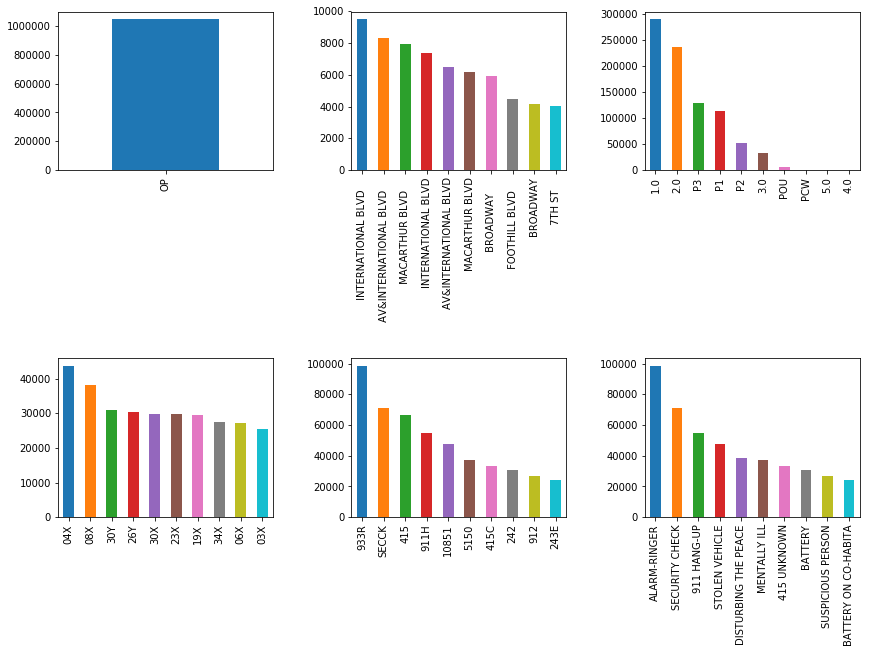

In [10]:
atts = nom_att[:-1]
plt.figure(figsize=(12,12))
for i,att in enumerate(atts):
    plt.subplot(3,3,i+1)
    data_nom[att].value_counts().head(10).plot.bar()
plt.tight_layout(pad=0.4, w_pad=3.0, h_pad=3.0)
plt.show()

### 3.2 使用盒图检查数据分布及离群点

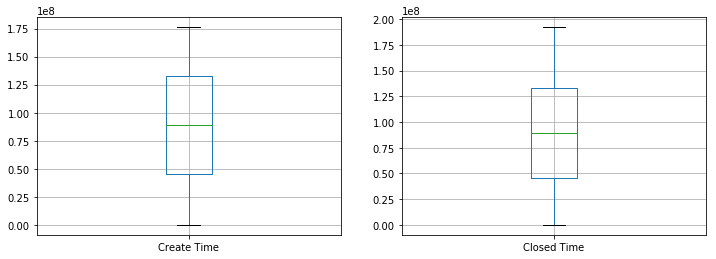

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
DataFrame(Create_Time).boxplot()
plt.subplot(1,2,2)
DataFrame(Closed_Time).boxplot()

可以看出存在个别案件处理时间非常长

## 4.数据缺失的处理

### 4.1 缺失数据分析

首先统计所有属性的缺失值情况

In [12]:
DataFrame(data.isnull().sum(),columns=['null_count']).T

,Agency,Create Time,Location,Area Id,Beat,Priority,Incident Type Id,Incident Type Description,Event Number,Closed Time
null_count,4,4,112,182365,5805,4,4,392,4,29


可以看出每个案件警方的巡逻区域存在大量额缺失，缺失原因很有可能是警员没有记录，其他属性都存在4个缺失，应当是操作失误导致插入数据，下面可视化缺失值进行分析

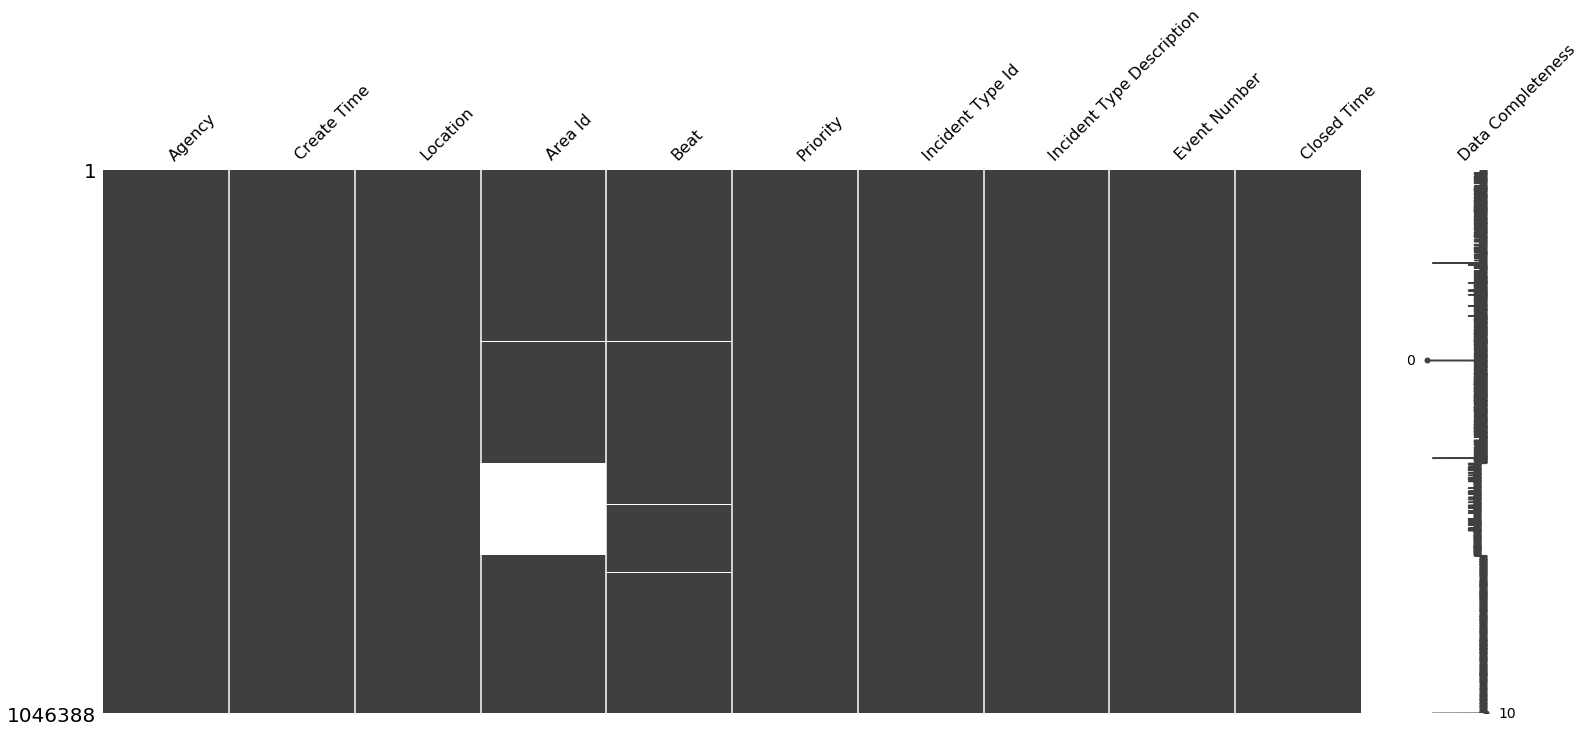

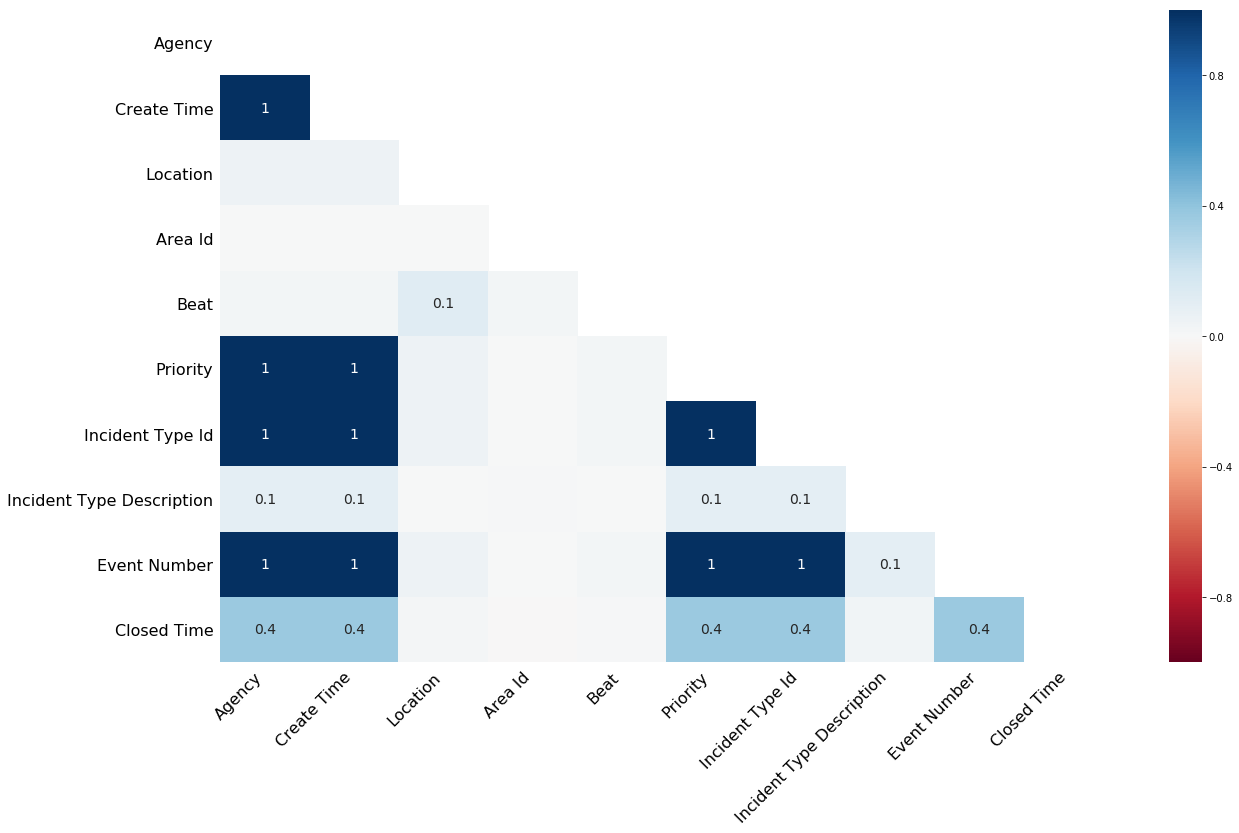

In [13]:
msno.matrix(data, labels=True)
msno.heatmap(data)

可以发现缺失个数为4的所有属性缺失相关性都为一，先前的猜想应该是正确的，为了进一步确认，将有问题的这一行进行输出

In [14]:
data[data['Agency'].isnull()]

,Agency,Create Time,Location,Area Id,Beat,Priority,Incident Type Id,Incident Type Description,Event Number,Closed Time
180015,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
555498,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1046387,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN


发现问题数据是最后一个数据项，在location处存储了一个空字符，因此应当是操作失误导致的，直接删除这些数据

In [15]:
data.drop(data[data['Agency'].isnull()].index,inplace=True)
DataFrame(data.isnull().sum(),columns=['null_count']).T

,Agency,Create Time,Location,Area Id,Beat,Priority,Incident Type Id,Incident Type Description,Event Number,Closed Time
null_count,0,0,111,182361,5801,0,0,388,0,25


### 4.2 缺失值处理

Location、Area Id、Beat三个属性相互关联，Incident Type Description与Incident Type Id相关联，Closed Time必须要大于Create Time

#### 4.21 将缺失部分剔除

In [16]:
data1 = data.copy(deep = True)
data1.dropna(axis=0, how='any', inplace=True)

#### 4.22 用最高频率值来填补缺失值

In [17]:
data2 = data.copy(deep = True)
null_att = ['Location','Area Id','Beat','Incident Type Description','Closed Time']
for att in null_att:
    data2[att].fillna(data2[att].mode()[0],inplace=True)

#### 4.23 通过数据对象之间的相似性来填补缺失值

由于数据集中大多数属性都是标称属性，并且数值属性只有日期，而时间和地点没有必然联系，不会在某一时间必然在某一区域发生案件，因此利用标称属性的相异性计算数据对象之间的相似度矩阵

In [18]:
nom_att = ['Location','Area Id','Beat','Priority','Incident Type Id','Incident Type Description']
data3 = data.copy(deep = True)
unkonw = data3[data3['Beat'].isnull()]
loc = unkonw.index.tolist()[0] 
unkonw_nom = unkonw[nom_att]
unkonw_num = unkonw[num_att]
konw = data3[data3['Beat'].notnull()]
konw_nom = konw[nom_att]
konw_num = konw[num_att]
cnt = len(nom_att)-1
max_num = data3[num_att].max()
min_num = data3[num_att].min()
batch_size=1000
data_size = unkonw.shape[0]
n = int(data_size/batch_size)
res=[]
print('please waiting ......')
for i in range(n+1):
    start = i*batch_size
    end = min(start+batch_size,data_size)
    d_nom = (np.expand_dims(unkonw_nom[start:end],1)!= np.expand_dims(konw_nom,0)).sum(axis=2)-1
    d = d_nom / cnt
    res.extend(np.argmin(d,axis=1).tolist())
    tmp = np.argmin(d, axis=1).tolist()[0]
predicted = konw.iloc[res, 4]
data3.loc[(data3['Beat'].isnull()), 'Beat'] = predicted.values
pd.concat([DataFrame(unkonw.iloc[0][nom_att]).T,DataFrame(konw.iloc[res[0]][nom_att]).T,DataFrame(data3.iloc[loc][nom_att]).T])

please waiting ......


,Location,Area Id,Beat,Priority,Incident Type Id,Incident Type Description
84,FOOTHILL WAY,3,NaN,1,943,FIGHT
46,62ND AV,3,26Y,1,943,FIGHT
84,FOOTHILL WAY,3,26Y,1,943,FIGHT


为了观察结果是否正确，以Beat为例，结果中第一行展示了了第一条Beat缺失的数据对象，第二行是通过计算相异性找到的与之最相似的数据对象，可以发现找到的数据项与之非常相似，最后一行是对第一行数据利用找到的第二行数据的Beat进行缺失值填充后的结果

#### 4.24 通过属性的相关关系来填补缺失值

利用所有标称属性训练随机森林算法进行缺失值填补

In [20]:
data4 = data.copy(deep = True)
col_list = ['Location','Area Id','Beat','Priority','Incident Type Id','Incident Type Description']
def processing(miss_col):
    col_list.remove(miss_col)
    col_list.append(miss_col)
    process_df = data.loc[:, col_list].copy(deep = True)
    class_le = LabelEncoder()
    for i in col_list[:-1]:
        process_df.loc[:, i] = class_le.fit_transform(process_df.loc[:, i].values.astype(str))
    known = process_df[process_df[miss_col].notnull()].values
    known[:, -1] = class_le.fit_transform(known[:, -1])
    unknown = process_df[process_df[miss_col].isnull()].values
    X = known[:, :-1]
    y = known[:, -1]
    rfr = ensemble.RandomForestRegressor(random_state=1, n_estimators=200, max_depth=8, n_jobs=-1)
    rfr.fit(X, y)
    predicted = rfr.predict(unknown[:, :-1]).round(0).astype(int)
    predicted = class_le.inverse_transform(predicted)
    data4.loc[(data[miss_col].isnull()), miss_col] = predicted
#processing('Location')
#processing('Area Id')
processing('Beat')
#processing('Incident Type Description')

### 4.3 可视化对比新旧数据集

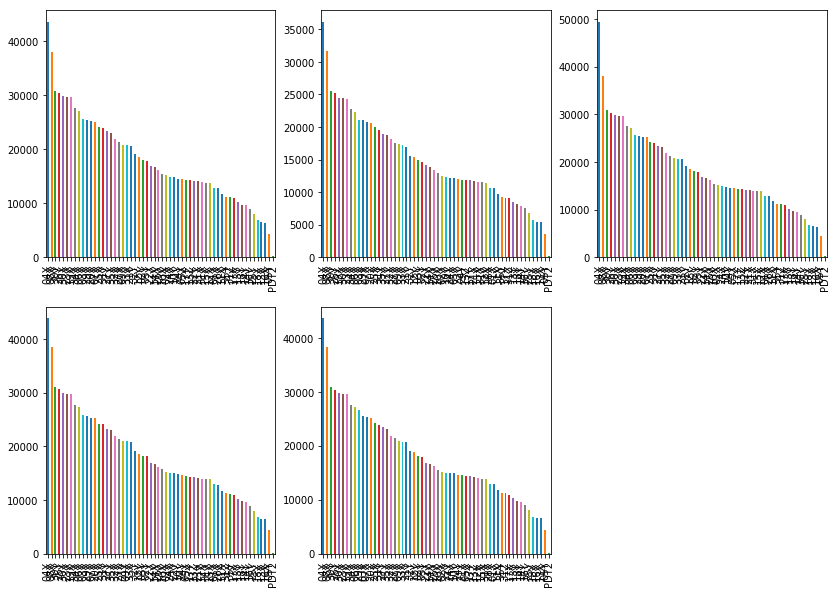

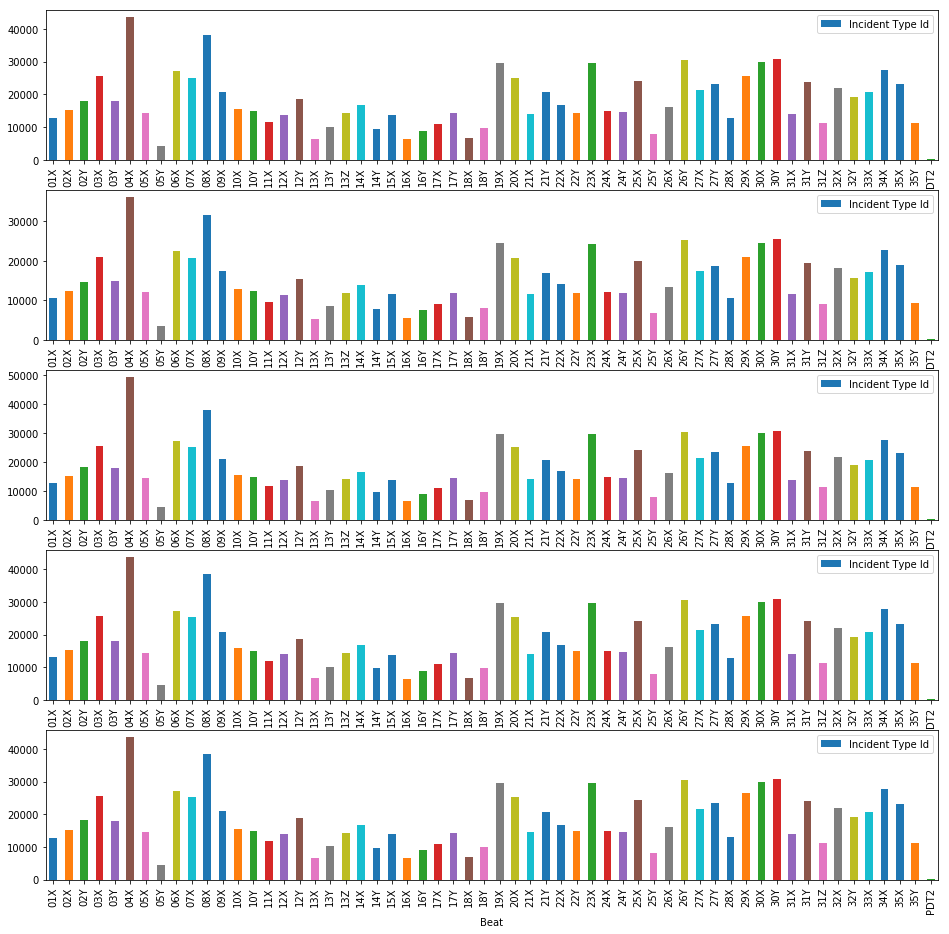

In [24]:
plt.figure(figsize=(14,10))
plt.subplot(231)
data['Beat'].value_counts().plot(kind='bar')
plt.subplot(232)
data1['Beat'].value_counts().plot(kind='bar')
plt.subplot(233)
data2['Beat'].value_counts().plot(kind='bar')
plt.subplot(234)
data3['Beat'].value_counts().plot(kind='bar')
plt.subplot(235)
data4['Beat'].value_counts().plot(kind='bar')
fig = plt.figure(figsize=(16,16))
ax0 =fig.add_subplot(511)
ax1 =fig.add_subplot(512)
ax2 =fig.add_subplot(513)
ax3 =fig.add_subplot(514)
ax4 =fig.add_subplot(515)
data.pivot_table(index=['Beat'], values='Incident Type Id', aggfunc=len).plot.bar(y='Incident Type Id',ax=ax0)
data1.pivot_table(index=['Beat'], values='Incident Type Id', aggfunc=len).plot.bar(y='Incident Type Id',ax=ax1)
data2.pivot_table(index=['Beat'], values='Incident Type Id', aggfunc=len).plot.bar(y='Incident Type Id',ax=ax2)
data3.pivot_table(index=['Beat'], values='Incident Type Id', aggfunc=len).plot.bar(y='Incident Type Id',ax=ax3)
data4.pivot_table(index=['Beat'], values='Incident Type Id', aggfunc=len).plot.bar(y='Incident Type Id',ax=ax4)

由于Beat是最具体的地址，因此首先绘制Beat属性单变量的数据分布图，从左至右自上而下分别对应原数据集和四种方法，可以看出前两种填充方法明显影响了数据分布，而最后两种方法都能很好的保持数据集的分布。

然后绘制了不同巡逻区域Beat对应发生的案件数的双变量柱状图，其中众数填充方法效果和原数据集依然有显著差异，通过数据对象之间的相似性来填补缺失值以及通过属性的相关关系来填补缺失值都保持了两变量之间的关系。

综上由于缺失数据较少的原因，通过数据对象之间的相似性来填补缺失值以及通过属性的相关关系来填补缺失值都能达到很好的效果。